In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Directories
energy_dir   = Path("energyData_clean")        # energy CSVs
temp_dir     = Path("temperatureData_clean")   # the files you screenshotted
temp_filled  = Path("temperatureData_filled")  # output folder
temp_filled.mkdir(exist_ok=True)

In [2]:
# Climatology builder
def build_climatology(ts: pd.Series) -> pd.Series:
    clim = ts.groupby(ts.index.dayofyear).mean()
    # ensure every DOY 1-366 is present, interpolate the few that aren’t
    return (clim.reindex(range(1, 367))
                .interpolate(limit_direction="both"))


✅  AEP: filled temperatures saved → temperatureData_filled\AEP_filled.csv


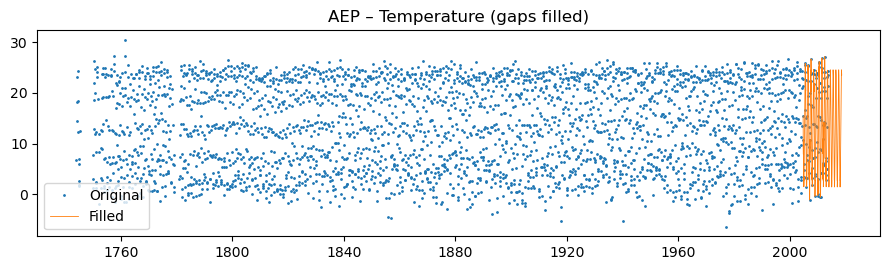

✅  COMED: filled temperatures saved → temperatureData_filled\COMED_filled.csv


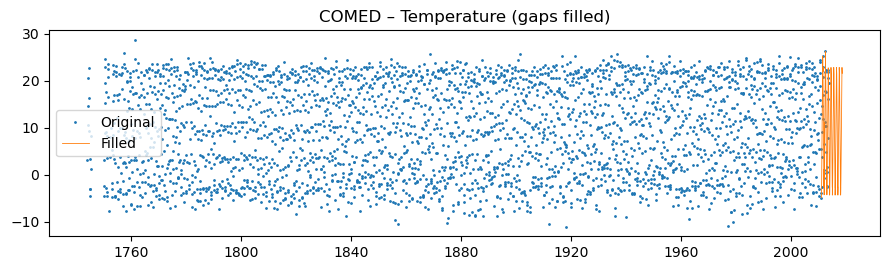

✅  DAYTON: filled temperatures saved → temperatureData_filled\DAYTON_filled.csv


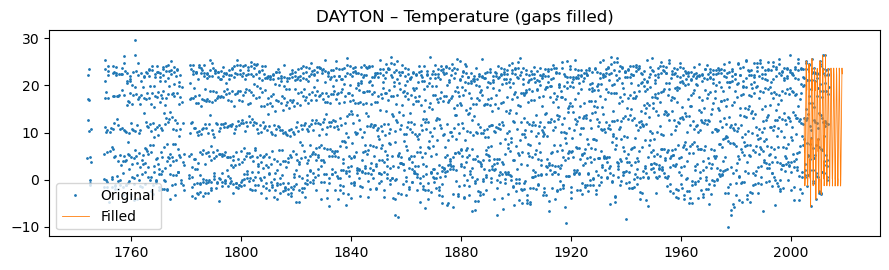

✅  DEOK: filled temperatures saved → temperatureData_filled\DEOK_filled.csv


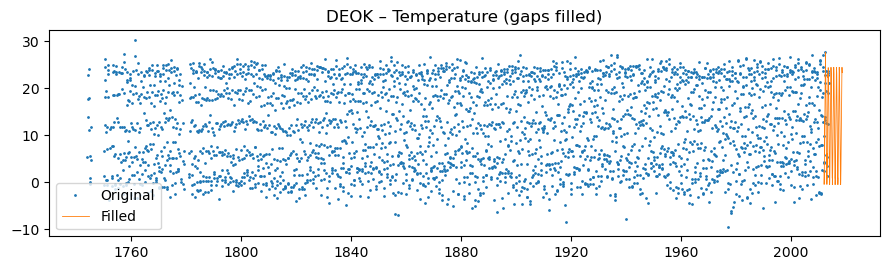

✅  DOM: filled temperatures saved → temperatureData_filled\DOM_filled.csv


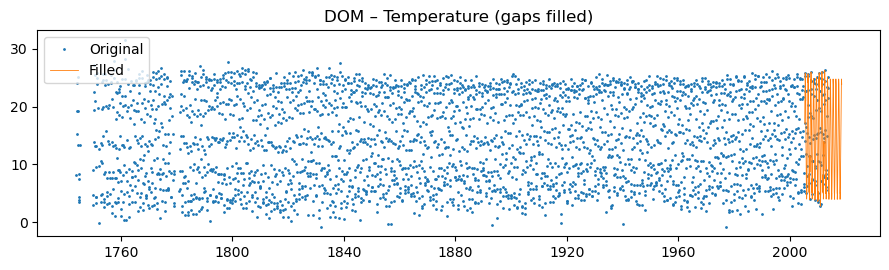

✅  DUQ: filled temperatures saved → temperatureData_filled\DUQ_filled.csv


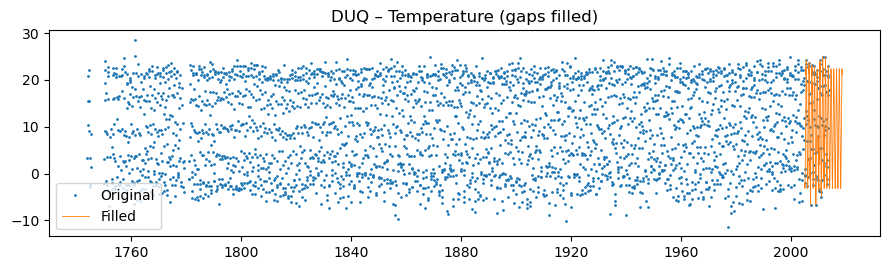

✅  EKPC: filled temperatures saved → temperatureData_filled\EKPC_filled.csv


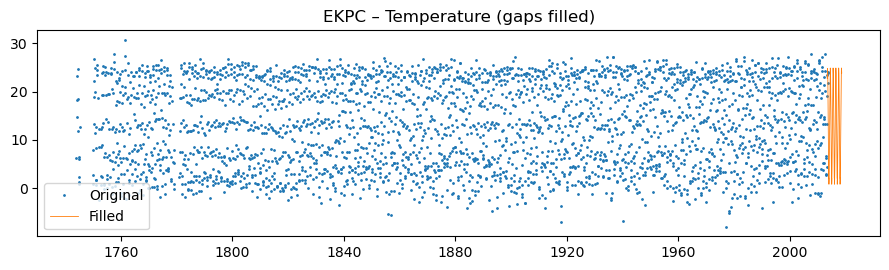

✅  FE: filled temperatures saved → temperatureData_filled\FE_filled.csv


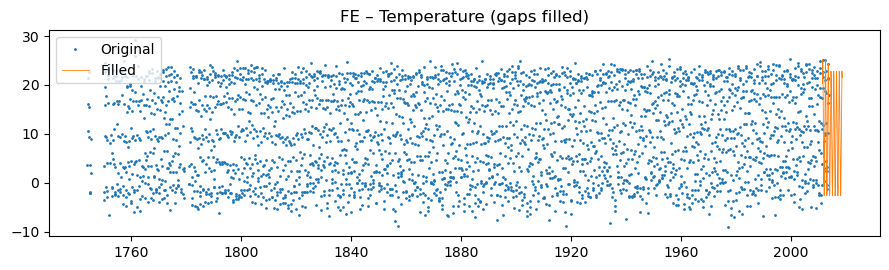

✅  NI: filled temperatures saved → temperatureData_filled\NI_filled.csv


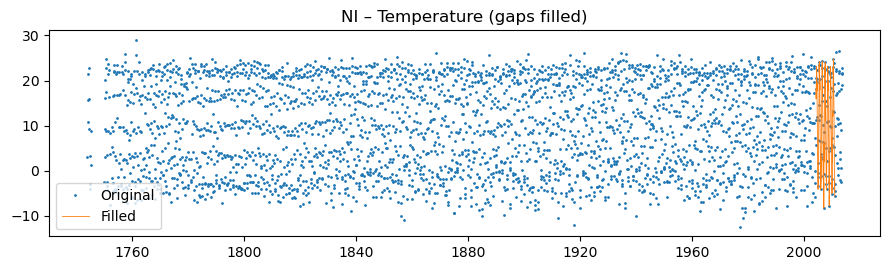

✅  PJME: filled temperatures saved → temperatureData_filled\PJME_filled.csv


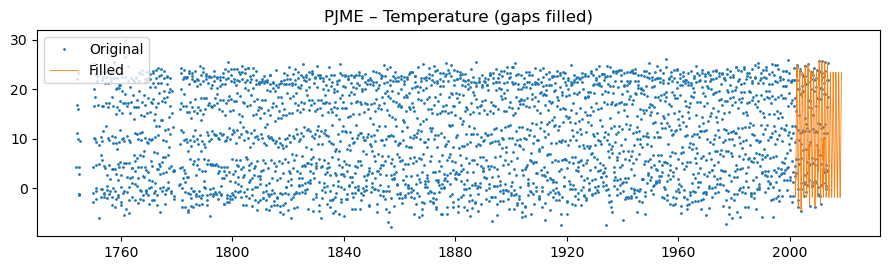

✅  PJMW: filled temperatures saved → temperatureData_filled\PJMW_filled.csv


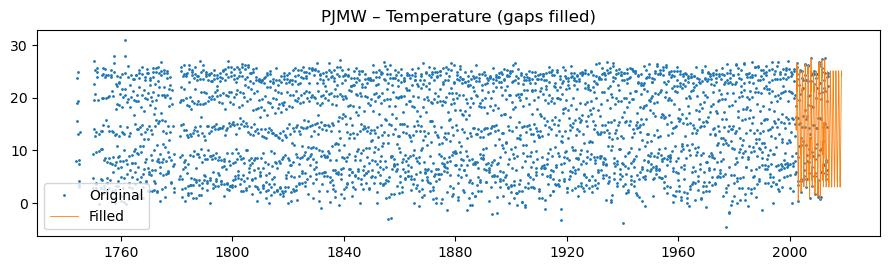

✅  PJM: filled temperatures saved → temperatureData_filled\PJM_filled.csv


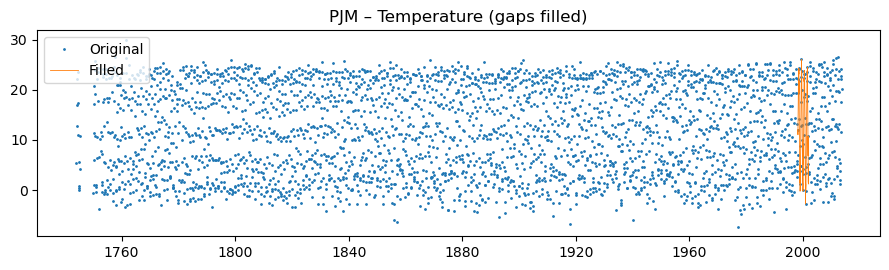

In [3]:
# Loop through each energy file/region
for efile in energy_dir.glob("*_hourly_daily.csv"):
    region = efile.stem.split("_")[0]          # e.g. "AEP"

    # ▸ Find every temp file that starts with that region_
    tfiles = sorted(temp_dir.glob(f"{region}_*.csv"))
    if not tfiles:
        print(f"⚠️  No temperature CSVs found for region {region}")
        continue

    # ▸ Load & combine them
    tframes = [pd.read_csv(f, parse_dates=["Date"]) for f in tfiles]
    temp_df = (pd.concat(tframes, ignore_index=True)
                 .groupby("Date")["Temp_C"]
                 .mean()
                 .to_frame()
                 .sort_index())
    temp_series = temp_df["Temp_C"]

    # ▸ Full daily index based on the region’s ENERGY dates
    eidx = pd.read_csv(efile, index_col=0, parse_dates=True).index
    full_index = pd.date_range(eidx.min(), eidx.max(), freq="D")
    temp_full = temp_series.reindex(full_index)

    # ▸ Fill gaps using the climatology pattern
    clim = build_climatology(temp_series)
    missing = temp_full.isna()
    temp_full[missing] = full_index[missing].map(lambda d: clim[d.dayofyear])

    # ▸ Save the filled series
    out_path = temp_filled / f"{region}_filled.csv"
    temp_full.to_frame(name="Temp_C").to_csv(out_path)
    print(f"✅  {region}: filled temperatures saved → {out_path}")

    # ▸ Optional quick plot for sanity
    plt.figure(figsize=(9,2.8))
    plt.plot(temp_series.index, temp_series, ".", ms=2, label="Original")
    plt.plot(temp_full.index, temp_full, "-", lw=0.6, label="Filled")
    plt.title(f"{region} – Temperature (gaps filled)")
    plt.legend(); plt.tight_layout(); plt.show()